Importa o modelo a ser fatiado e mapeado

In [18]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
Total de [criando as camadas] : 0.3787686824798584
salvando as camadas
Total de [salvando as camadas] : 0.07639002799987793
Total de [Fase 0: ] : 0.45551085472106934


Paredes Finas

In [19]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.0001239776611328125
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0572361946105957
Total de [Criando paredes finas] : 12.613827466964722
Total de [Fase 1: Camada: 0] : 12.643391847610474


Contornos

In [20]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 9
Total de [Criando Lvls] : 7.536608457565308
Criando os loops
Total de [Criando os loops] : 5.339350700378418
Criando regiões de influência
Total de [Criando regiões de influência] : 1.271442174911499
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.3941597938537598
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:2382 maior void:0.33877038895859474Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:1929 maior void:0.5872020075282308Bw -> aceito
['Lvl_002', 0, 0] Perdendo total:1636 maior void:0.5131744040150564Bw -> aceito
['Lvl_003', 0, 0] Perdendo total:1637 maior void:0.5131744040150564Bw -> aceito
['Lvl_004', 0, 0] Perdendo total:9614 maior void:5.503136762860728Bw -> bloqueado
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 2] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 3] Perdendo total:442

Pontes

In [1]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        c.make_bridges(n_max, nozzle_diam_internal, folders)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c" 
%reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 7.673038959503174
Criando pontes de Zigzag
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou ponte
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou ponte
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou ponte
teste: caso de uma unica linha no entorno da origem
[3#mErro: nao fechou ponte
[3#mFechou uma ponte OK
Total de [Criando pontes de Zigzag] : 32.269893407821655
Criando pontes de Crossover
Total de [Criando pontes de Crossover] : 0.13924145698547363
Retirando pontes da Camada
Total de [Retirando pontes da Camada] : 0.055098533630371094
salvando imagens das regiões
Total de [salvando imagens das regiões] : 1.0778677463531494
Total de [Fase 3: Camada: 0] : 41.33148503303528


Zigzags

In [2]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 18.972053050994873
salvando imagens das regiões
Total de [salvando imagens das regiões] : 0.2108471393585205
Total de [Fase 4: Camada: 0] : 20.031051874160767


Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 1.9482979774475098


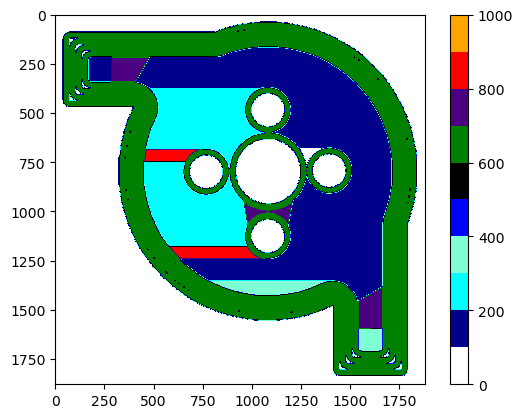

In [3]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [4]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.4207336902618408
Total de [Making offset routes] : 20.44556951522827


Rotas de pontes

In [5]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes


/home/matheus/Downloads/Tangran3/TangranV2/components/bottleneck.py:1323: RuntimeWarning: invalid value encountered in divide
  v1_hat = v1_vec / np.linalg.norm(v1_vec)
/home/matheus/Downloads/Tangran3/TangranV2/components/bottleneck.py:1330: RuntimeWarning: invalid value encountered in divide
  v2_hat = v2_vec / np.linalg.norm(v2_vec)


salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.6425764560699463
Total de [Making bridges routes] : 44.09643626213074


Rotas de Ziguezague

In [6]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 22.848602294921875
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4425497055053711
fazendo as tres opções:
Total de [fazendo as tres opções:] : 20.860206604003906
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4561445713043213
fazendo as tres opções:
Total de [fazendo as tres opções:] : 0.08060264587402344
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.1927964687347412
fazendo as tres opções:
Total de [fazendo as tres opções:] : 30.623536586761475
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4951620101928711
fazendo as tres opções:
Total de [fazendo as tres opções:] : 18.339242696762085
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.45762181282043457
fazendo as tres opções:
Total de [fazendo as tres opções:] : 34.15573191642761
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.567264

Weaving

In [7]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[internal_weaving] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(internal_weaving, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Total de [gerando preenchimentos oscilatórios] : 57.36977434158325
salvando rotas
Total de [salvando rotas] : 0.4090447425842285
Total de [Fase 5 b] : 57.78042912483215


Rotas de Thin Walls

In [8]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 4.410743713378906e-05
Total de [Making thin walls routes] : 0.10981297492980957
Total de [Fase 5] : 0.11003255844116211


Unificando rotas EXTERNAS nas camadas

In [9]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Encontrando ponto de união ext-int
33
Total de [Encontrando ponto de união ext-int] : 0.5225958824157715
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 35.44973301887512
Conectando pontes de Crossover
Total de [Conectando pontes de Crossover] : 8.0108642578125e-05
Total de [Conectando rotas externas] : 38.13287806510925
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.31807637214660645
Total de [Fase 6] : 38.45232367515564


Unificando rotas INTERNAS nas camadas

In [10]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 47.10807418823242
Conectando pontes de zigzag
salto:  [250, 270]
salto:  [1024, 955]
salto:  [1616, 1572]
Total de [Conectando pontes de zigzag] : 2.846130609512329
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.3849785327911377
Total de [Fase 7] : 52.529316663742065


Unindo rotas de thin walls

In [11]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.008278608322143555
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.22523188591003418
Total de [Fase 8] : 0.3517897129058838


Unindo todas as rotas e criando codigo G

In [ ]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall] = gui.ask_parameters_Gcode()
camadas = folders.load_layers_hdf5()

internal_trees = []
external_trees = []
tw_trees = []
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        
for c in camadas:
    c.close_final_path(folders)
    for isl in c.islands:
        internal_trees.append([list(x) for x in isl.internal_tree_route.sequence])
        external_trees.append([list(x) for x in isl.external_tree_route.sequence])
        tw_trees.append([list(x) for x in isl.thinwalls_tree_route.sequence])

with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               internal_trees,
                               external_trees,
                               tw_trees,
                               )
%reset_selective -f "camadas"

Value(False)


In [35]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

TypeError: unhashable type: 'list'

In [13]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [14]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)